In [144]:
from enum import Enum

import numpy as np
import torch.nn as nn
import torch.optim
from scipy.optimize import minimize, least_squares
from torch import float64
from torch.autograd import Variable

In [145]:
from linreg import Methods, LearningRateScheduling, LinearRegression


def optimizer_handler(method, params, lr, beta_1=0.9, beta_2=0.999, factor=10):
    match method:
        case Methods.Classic:
            return torch.optim.SGD(params, lr)
        case Methods.Momentum:
            return torch.optim.SGD(params, lr, beta_1)
        case Methods.AdaGrad:
            return torch.optim.Adagrad(params, lr * factor)
        case Methods.RMSprop:
            return torch.optim.RMSprop(params, lr, alpha=beta_2)
        case Methods.Adam:
            return torch.optim.Adam(params, lr, betas=(beta_1, beta_2))
        case Methods.Nesterov:
            return torch.optim.SGD(params, lr, nesterov=True, momentum=beta_1)


def lr_scheduler_handler(optimizer, lrs, lr, epoch_size=30):
    match lrs:
        case LearningRateScheduling.Classic:
            return torch.optim.lr_scheduler.LambdaLR(optimizer, lambda *_: 1)
        case LearningRateScheduling.Stepwise:
            return torch.optim.lr_scheduler.StepLR(optimizer, step_size=epoch_size, gamma=0.75)
        case LearningRateScheduling.Exponential:
            return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)


class TorchLinearRegression:
    def __init__(self, T, X, Y, W=None):
        self.T_funcs = T
        self.T = torch.tensor([T[i % len(T)](X[i // len(T)]) for i in range(len(T) * len(X))], dtype=float64).reshape(
            len(X), len(T))
        self.X = torch.tensor(X, dtype=float64)
        self.Y = torch.tensor(Y, dtype=float64)
        self.loss_f = nn.MSELoss(reduction='mean')

        self.refresh(W)

    def optimize(self, method=Methods.Classic, lr=0.01, lrs=LearningRateScheduling.Classic, max_steps=1500):
        optimizer = optimizer_handler(method, [self.W], lr)
        scheduler = lr_scheduler_handler(optimizer, lrs, lr=lr)

        for i in range(max_steps):
            optimizer.zero_grad()
            self.loss(self.W, is_no_grad=False)
            optimizer.step()
            self.W_points.append(self.W.clone().detach().numpy())
            scheduler.step()

        return self.W

    def loss(self, W, is_no_grad=True):
        if isinstance(W, np.ndarray):
            W = np.array(W).reshape(len(self.T_funcs), 1)
            W = Variable(torch.tensor(W, dtype=float64), requires_grad=True)
        if is_no_grad:
            with torch.no_grad():
                loss_val = self.loss_f(self.T @ W, self.Y)
                return float(loss_val) * len(self.X)
        else:
            loss_val = self.loss_f(self.T @ W, self.Y)
            loss_val.backward()
            return float(loss_val)

    def refresh(self, W=None):
        if isinstance(W, np.ndarray):
            W = np.array(W, dtype=float64).reshape(len(self.T_funcs), 1)
        if W is None:
            W = torch.randn(len(self.T_funcs), 1, dtype=float64)
        self.W = Variable(torch.tensor(W), requires_grad=True)
        self.W_points = [torch.clone(self.W).detach().numpy()]

    def analytical_solution(self):
        return (torch.linalg.inv(torch.t(self.T) @ self.T) @ torch.t(self.T)) @ self.Y

In [146]:
import tracemalloc
from time import time


class Metrics:
    def __init__(self, result, mem, time, other=None):
        if other is None:
            other = []
        self.result = result
        self.mem = mem
        self.time = time
        self.other = other


def get_metrics(func):
    start = time()
    tracemalloc.start()
    result = func()
    mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    end = time()

    return Metrics(result, mem[1] - mem[0], end - start)


In [147]:
from excel import ExcellSaver

excel_saver = ExcellSaver()


def add_metrics_row(metrics):
    global excel_saver

    row = []
    for pair in metrics.other:
        row.append(pair[1])
    row.append(metrics.time)
    row.append(metrics.mem)

    excel_saver.add_row(row)


In [148]:
from matplotlib import pyplot as plt

import random
from linreg import gen_linear_reg, visualise_approximation, sgd_handler

Output = Enum("Output", ["No", "Console", "Excel"])


def visualise(f, points, title, x_label="x", y_label="y"):
    values = np.transpose(np.array(points))
    X = np.linspace(min(values[0]) - 10, max(values[0]) + 10, 100)
    Y = np.linspace(min(values[1]) - 10, max(values[1]) + 10, 100)
    Z = [[f(np.array([X[i], Y[j]])) for i in range(len(X))] for j in range(len(Y))]
    plt.contour(X, Y, Z, 80)

    plt.plot(values[0], values[1], marker='.')
    plt.plot(values[0][0], values[1][0], 'og')
    plt.plot(values[0][-1], values[1][-1], 'or')
    plt.title(title)
    plt.legend(['Route', 'Start point', 'End point'])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show()


def add_abs_rel_errors_info(metrics, excepted, received):
    metrics.other.append(["Absolute Error", str(np.linalg.norm(excepted - received))])
    metrics.other.append(["Relative Error", str(np.linalg.norm(excepted - received) / np.linalg.norm(excepted))])


def add_linreg_errors_info(metrics, linreg):
    expected_linreg_loss = linreg.loss(linreg.analytical_solution())
    linreg_loss = linreg.loss(linreg.W)
    metrics.other.append(["Expected Loss", expected_linreg_loss])
    metrics.other.append(["Actual Loss", linreg_loss])


def test_sgd_variants(output=Output.No):
    global excel_saver

    if output == Output.Excel:
        excel_saver.add_new_sheet(["Whose", "Method", "Expected Loss", "Actual Loss", "Time", "Memory"],
                                  "Test SGD Methods")

    count_2_arity = 1
    count_other_arity = 0
    left_coeffs_border = -2.
    right_coeffs_border = 2.
    left_x_border = -2.
    right_x_border = 2.
    deviation = 3.

    for i in range(count_2_arity + count_other_arity):
        arity = 2 if i < count_2_arity else random.randint(3, 8)
        num_train_points = random.randint(50, 100)
        start_point = np.array([float(random.randint(15, 30)) for i in range(arity)])
        linreg = gen_linear_reg(
            arity - 1, num_train_points,
            left_coeffs_border, right_coeffs_border,
            left_x_border, right_x_border,
            deviation
        )
        torch_linreg = TorchLinearRegression(linreg.T_funcs, linreg.X, linreg.Y, torch.tensor(start_point))
        self_scheduled = (Methods.AdaGrad, Methods.Adam, Methods.RMSprop)

        for method in Methods:
            lr = 0.01
            if method in self_scheduled:
                lr = 0.1
                linreg.refresh(start_point)
                our_metrics = get_metrics(lambda: sgd_handler(linreg, lambda *_: lr, method, store_points=True))
                title = 'Our ' + method.name
                if len(linreg.T_funcs) == 2:
                    visualise(linreg.loss, linreg.W_points, title)
                visualise_approximation(linreg, title)

                title = 'Torch ' + method.name
                torch_linreg.refresh(torch.tensor(start_point))
                torch_metrics = get_metrics(lambda: torch_linreg.optimize(method, lr=lr))
                if len(torch_linreg.T_funcs) == 2:
                    visualise(torch_linreg.loss, torch_linreg.W_points, title)
                visualise_approximation(torch_linreg, title)

                match output:
                    case Output.Excel:
                        our_metrics.other.append(["Whose", "Our"])
                        our_metrics.other.append(["Method", method.name.replace("Methods.", "")])
                        add_linreg_errors_info(our_metrics, linreg)
                        add_metrics_row(our_metrics)

                        torch_metrics.other.append(["Whose", "Torch"])
                        torch_metrics.other.append(["Method", method.name.replace("Methods.", "")])
                        add_linreg_errors_info(torch_metrics, torch_linreg)
                        add_metrics_row(torch_metrics)
                    case Output.Console:
                        pass

# test_sgd_variants(Output.Excel)

In [149]:
def derivative(f, x, i, delt=0.0001):
    x_1 = np.copy(x)
    x_2 = np.copy(x)
    x_1[i] += delt
    x_2[i] -= delt
    y_1 = f(x_1)
    y_2 = f(x_2)
    return (y_1 - y_2) / (2 * delt)


def grad(f, delt=0.01):
    def grad_calc(x):
        array = []
        for i in range(len(x)):
            array.append(derivative(f, x, i, delt))
        return np.array(array)

    return grad_calc


def hessian(f):
    def calc(x):
        B = np.asarray([[0. for _ in range(len(x))] for _ in range(len(x))])
        for i in range(len(x)):
            for j in range(len(x)):
                B[i][j] = derivative(lambda x_tmp: derivative(f, x_tmp, j), x, i)
        return B

    return calc

In [150]:
Algorithms = Enum('Algorithms', ['Newton', 'DogLeg', 'BFGS', 'LBFGS'])


def optimize_handler(fun, x0, algorithm=Algorithms.Newton):
    match algorithm:
        case Algorithms.Newton:
            return least_squares(fun, x0)
        case Algorithms.DogLeg:
            return minimize(fun, x0, method='dogleg', jac=grad(fun), hess=hessian(fun))
        case Algorithms.BFGS:
            return minimize(fun, x0, method='BFGS')
        case Algorithms.LBFGS:
            return minimize(fun, x0, method='L-BFGS-B')


def our_optimize_handler(fun, x0, algorithm=Algorithms.Newton):
    match algorithm:
        case Algorithms.Newton:
            return gauss_newton(x0, fun)
        case Algorithms.DogLeg:
            return dogleg(fun, x0)
        case Algorithms.BFGS:
            return bfgs(fun, x0)
        case Algorithms.LBFGS:
            return lbfgs(fun, x0)

In [151]:
#gen random excepted coeffs
def gen_excepted(lb=-10, rb=10, min_size=2, max_size=10):
    return np.random.uniform(lb, rb, size=(np.random.randint(min_size, max_size)))


#gen parameters with poly functions of points
def gen_parameters(excepted, N=100, deviation=0.01, is_random_N=False, lb_N=50, rb_N=200):
    M = len(excepted)
    if is_random_N:
        N = np.random.randint(lb_N, rb_N)

    noise = torch.randn(N, 1, dtype=float64) * deviation
    powers = [(M - 1 - i) for i in range(M)]
    Funcs = np.array([lambda x, i=i: (x ** powers[i]) for i in range(M)])
    X = torch.randn(N, 1, dtype=float64)
    Y = sum([float(excepted[i]) * Funcs[i](X) for i in range(M)]) + noise
    T = torch.zeros(len(X), len(Funcs), dtype=float64)
    for i in range(len(X)):
        for j in range(len(Funcs)):
            T.data[i, j] = Funcs[j](X.data[i])

    return (X, Y, T, Funcs)


#gen least squares loss function
def gen_f(X, Y, T, Funcs):
    def f(W):
        W1 = None
        if isinstance(W, torch.Tensor):
            W1 = W
        else:
            W1 = np.copy(W).reshape(len(Funcs), 1)
            W1 = torch.tensor(W1, dtype=float64)
        model = T.mm(W1)
        mse = nn.MSELoss()
        res = mse(model, Y)
        return res if isinstance(W, torch.Tensor) else res.item()

    return f


#gen random x0
def gen_x0(len, lb=-20, rb=20):
    return np.random.uniform(lb, rb, size=len)


#numeric grad for any function
def num_grad(f, delt=0.01):
    return grad(f, delt=delt)


#analityc grad for any linear function of weights with the least squares problem
def an_grad(X, Y, T, Funcs):
    M = len(Funcs)

    def an_grad_calc(W):
        array = []
        components_value = ((T @ torch.tensor(W, dtype=float64).reshape(len(W), 1)) - Y)
        for i in range(M):
            x_fi = Funcs[i](X)
            array.append((x_fi.T @ components_value).item())
        return np.array(array)

    return an_grad_calc


#torch grad for any function with the least squares problem
def torch_grad(f):
    def torch_grad_calc(W):
        x = torch.tensor(W, dtype=float64, requires_grad=True).reshape(len(W), 1)
        x.retain_grad()
        Q = f(x)
        Q.backward()
        return x.grad.T.detach().numpy().reshape(len(W))

    return torch_grad_calc

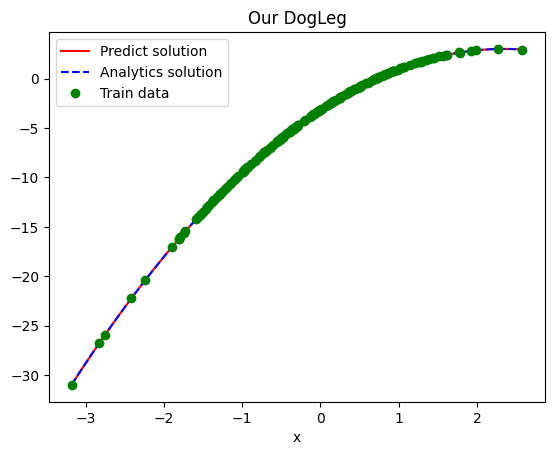

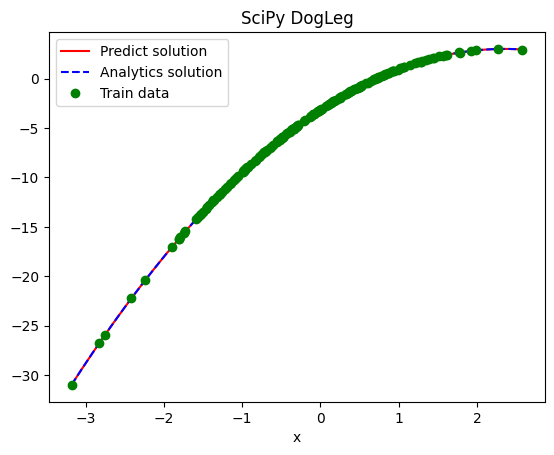

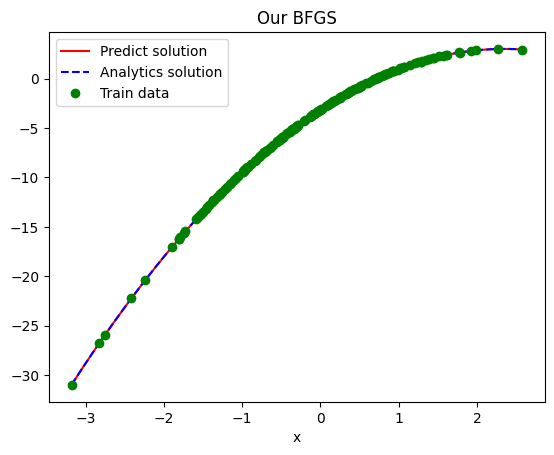

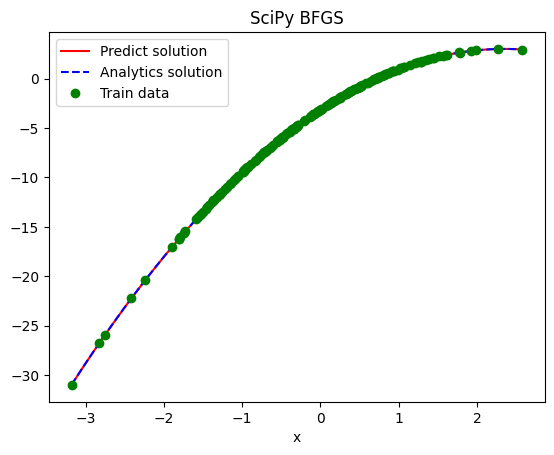

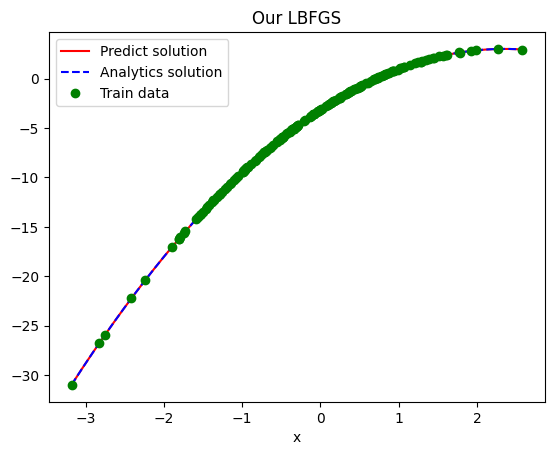

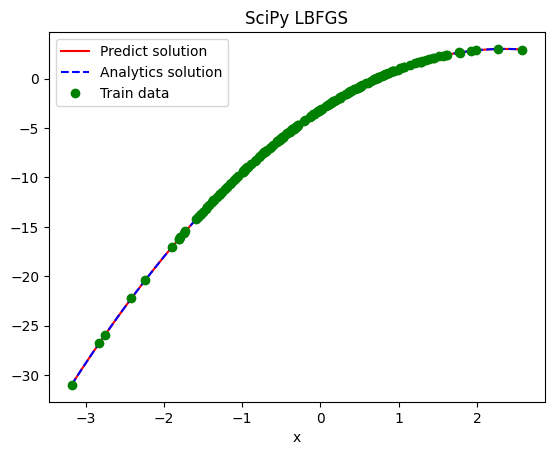

In [152]:
from trustreg import gauss_newton, dogleg, bfgs, lbfgs


def test_pytorch_grad(output: Output.No):
    global excel_saver

    if output == Output.Excel:
        excel_saver.add_new_sheet(["Whose", "Algorithm", "Absolute Error", "Relative Error", "Time", "Memory"])

    count_examples = 1
    for _ in range(count_examples):
        expected = gen_excepted(max_size=4)
        X, Y, T, Funcs = gen_parameters(expected, is_random_N=True)
        f = gen_f(X, Y, T, Funcs)
        x0 = gen_x0(len(Funcs))

        def tmp(i):
            def culc(W):
                print(W.shape)
                print(T.shape)
                return torch.tensor(W) @ torch.t(T[i]) - Y[i]

            return culc

        for algorithm in Algorithms:
            scipy_metrics = get_metrics(lambda: optimize_handler(f, x0, algorithm))
            our_metrics = None
            if algorithm == Algorithms.Newton:
                continue
                funcs = [tmp(i) for i in range(len(X))]
                our_metrics = get_metrics(lambda: our_optimize_handler(funcs, x0, algorithm))
            else:
                our_metrics = get_metrics(lambda: our_optimize_handler(f, x0, algorithm))

            linreg = LinearRegression(Funcs, our_metrics.result, X.detach().numpy(), Y.detach().numpy())
            scipy_linreg = LinearRegression(Funcs, scipy_metrics.result.x, X.detach().numpy(), Y.detach().numpy())

            visualise_approximation(linreg, f"Our {algorithm.name.replace('Algorithms', '')}")
            visualise_approximation(scipy_linreg, f"SciPy {algorithm.name.replace('Algorithms', '')}")

            match output:
                case Output.Excel:
                    our_metrics.other.append(["Whose", "Our"])
                    our_metrics.other.append(["Algorithm", algorithm.name.replace("Algorithm.", "")])
                    add_abs_rel_errors_info(our_metrics, expected, our_metrics.result)
                    add_metrics_row(our_metrics)

                    scipy_metrics.other.append(["Whose", "SciPy"])
                    scipy_metrics.other.append(["Algorithm", algorithm.name.replace("Algorithm.", "")])
                    add_abs_rel_errors_info(scipy_metrics, expected, scipy_metrics.result.x)
                    add_metrics_row(scipy_metrics)


test_pytorch_grad(Output.Excel)

In [153]:
#2.b

#Grads
# num_grad_f1 = num_grad(f1)
# an_grad_f1 = an_grad(X1, Y1, T1, Funcs1)
# torch_grad_f1 = torch_grad(f1)
#
# #Calculations
# with_num_grad = minimize(f1, x0_1, method='CG', jac=num_grad_f1).x
# with_an_grad = minimize(f1, x0_1, method='CG', jac=an_grad_f1).x
# with_torch_grad = minimize(f1, x0_1, method='CG', jac=torch_grad_f1).x
#
# print("Example 2.b")
# print("-------------------------")
# print_errors(excepted, with_num_grad, suf="with num grad")
#
# print()
#
# print_errors(excepted, with_an_grad, suf="with an grad")
#
# print()
#
# print_errors(excepted, with_torch_grad, suf="with torch grad")
# print("-------------------------")

In [154]:
BoundMethods = Enum('BoundMethods', ['Nelder-Mead', 'L-BFGS-B', 'TNC', 'SLSQP', 'Powell', 'trust-constr'])


def gen_bounds(arity, left_bound=-20, right_bound=20, delta_between=3):
    bounds = []
    for _ in range(arity):
        min_val = random.randint(left_bound, right_bound)
        max_val = random.randint(min_val + delta_between, right_bound + delta_between)
        bounds.append([min_val, max_val])

    return bounds


def gen_start_point_by_bounds(bounds):
    x0 = []

    for i in range(len(bounds)):
        x0.append(random.uniform(bounds[i][0], bounds[i][1]))

    return np.array(x0)

In [155]:
def test_scipy_bounds(f, method, arity, max_shift=2):
    print("-------------------------")

    bounds = gen_bounds(arity)
    for i in range(len(bounds)):
        print(f"Changing x{i + 1}'s bound")

        for bound_part in [0, 1]:
            sign = 1 if bound_part == 0 else -1
            for d in range(min(max_shift, bounds[i][1] - bounds[i][0]) + 1):
                if d == 0 and not (i == 0 and bound_part == 0):
                    continue

                bounds[i][bound_part] += sign * d
                x0 = gen_start_point_by_bounds(bounds)

                print("Bounds:")
                print('\n'.join([f"{bounds[j][0]} <= x{j + 1} <= {bounds[j][1]}" for j in range(len(bounds))]))
                metrics = get_metrics(lambda *_: minimize(f, x0, method=method, bounds=bounds))
                bounds[i][bound_part] -= sign * d

                print(f"Method: {method}\nResult: {metrics.result.x}\nMemory: {metrics.mem}\nTime: {metrics.time}")
                print()

In [156]:
def f(x):
    return x[0] ** 2 + x[1] ** 2


for bound_method in BoundMethods:
    test_scipy_bounds(f, bound_method.name.replace("BoundMethods", ""), 2)

-------------------------
Changing x1's bound
Bounds:
-19 <= x1 <= 7
-18 <= x2 <= -13
Method: Nelder-Mead
Result: [ 3.26093376e-05 -1.30000000e+01]
Memory: 7501
Time: 0.009518861770629883

Bounds:
-18 <= x1 <= 7
-18 <= x2 <= -13
Method: Nelder-Mead
Result: [ 1.64902186e-05 -1.30000000e+01]
Memory: 7397
Time: 0.0

Bounds:
-17 <= x1 <= 7
-18 <= x2 <= -13
Method: Nelder-Mead
Result: [-4.11559014e-06 -1.30000000e+01]
Memory: 7397
Time: 0.0

Bounds:
-19 <= x1 <= 6
-18 <= x2 <= -13
Method: Nelder-Mead
Result: [ 2.30651622e-05 -1.30000000e+01]
Memory: 7427
Time: 0.015643835067749023

Bounds:
-19 <= x1 <= 5
-18 <= x2 <= -13
Method: Nelder-Mead
Result: [  5. -13.]
Memory: 7498
Time: 0.0

Changing x2's bound
Bounds:
-19 <= x1 <= 7
-17 <= x2 <= -13
Method: Nelder-Mead
Result: [-2.13162821e-14 -1.30000000e+01]
Memory: 7482
Time: 0.0

Bounds:
-19 <= x1 <= 7
-16 <= x2 <= -13
Method: Nelder-Mead
Result: [ 1.15903748e-05 -1.30000000e+01]
Memory: 7397
Time: 0.0

Bounds:
-19 <= x1 <= 7
-18 <= x2 <= -14


In [157]:
excel_saver.create_excel()